In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# specific libraries or classes needed for the work in this notebook
from sklearn.model_selection import LeaveOneGroupOut
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate

# Replication 01: Basic Replication Steps

In this notebook, the goal is to try and put together the developed pieces we have so far to see how well we can replicate the
results reported in the reference paper this project is replicating.

This notebook will not attempt the full replication.  The paper reported the following about the best model that was achieved:

```
Notably, the
17 best models (each with an AUROC above .63) were all
logistic regression models with a window size of 12 s. The
overall best model achieved an AUROC of .64, which reflects
a 28% improvement over a chance model (AUROC = .50).
This model used a total of 24 features after tolerance analysis
and feature selection. The outliers in this model were
Winsorized, and the training set was downsampled.
```

It is still surprising to me that logistic regression models were being seen here as outperforming some of the
other candidates, which included SVM, k-nn, decision tree and random forest among others.

From the above quote, we will try to train a LogisticRegression model.  Other goals of this notebook are
to display the results of the training, including plotting the AUROC curve, and determing the
AUROC score.  Hopefully we can replicate the reported score, and also determine the raw
accuracy (and recall and precision) being achieved.  It is not clear if this is much better than
a 78% accurace one might get from just guessing the majority class, though this should not be the case
since AUROC is based on combination of precision and recall.  So an AUROC score of 0.64 is a goal to keep
in mind.

The best model used 28 features after tolerance analysis and feature selection.  We know they had 32 features, so
the reported best model was feature selected with 75% of them.  It is unclear why, if the best model
was using the upper limit of their feature selection, they didn't also try 100% of the features.
We can try that in later replication experiments, as well as using more than the 32 selected by the vif tolerance.

In addition, we should use leave-one-participant out cross validation training, as described, and the best model
was reported to happen with simple downsampling, so we will only use that in this notebook.  We will
use our standard scaled data set that is Winsorized to remove outliers as they report for their best model
as well.

This gives us I think all we need to try and build a replication of the best reported model.  We need to

1. Use the standard scaled features to begin with.
2. Remove outliers using Winsorization.
3. Use vif to reduce colinearity.  We will use the 32 features our vif determines, which doesn't exactly match the ones shown in paper.
4. Perform feature selection using our version of the correlation scores to rank features.  We will do this this time only on the 32 features
   we have, and keep the top 75% (28 features).
5. Create a logistic regression model and train it to convergence using leave-one-participant-out cross validation.  We will downsample
   the majority class using random under sampling for train data only while training the classifier.
6. Once converged, then, we shall look at raw accuracy, recall and precision, and draw the AUROC curves.

It is not clear to me if we should pull out an ultimate test set of say 10% of the participants or so, and then do the final evaluation on this
data.  I think I will do this, though I am not sure if they were using a held back test set in their report here.  To do this, once we have done
steps 1-4 and selected features, that would be the time to split some percentage to hold back for after we finish training the model.

# 1. Use the Standard Scaled Features

# 2. Remove Outliers using Winsorization

Load the standard scaled features to begin with.  Actually we just load the pipeline that also removes outliers using Winzorization here.

Also need the labels to extract the `mind_wandered_label`, and the `experiment_metadata` so that we
can get the `participant_id` field for group selection of trials by participant.

In [2]:
# standard scaled data
df_features = mindwandering.data.get_df_features()
df_features = mindwandering.data.transform_df_features_standard_scaled(df_features)
df_features = mindwandering.data.transform_df_features_outliers_removed(df_features)

# mindwandered label
df_label = mindwandering.data.get_df_label()
df_label = df_label.mind_wandered_label

# participant ids
df_experiment_metadata = mindwandering.data.get_df_experiment_metadata()
participant_ids = df_experiment_metadata.participant_id

# 3. Use VIF to reduce Colinearity

Use the method we developed to calculate VIF.  We will use the threshold here to get our own 32 features that have lowest VIF scores.

In [3]:
# use vif scores to eliminate features and reduce colinearity so that we end up with the desired number of features
feature_ratio = 0.52
df_features = mindwandering.data.transform_df_features_vif_threshold(df_features, feature_ratio)

print(df_features.shape)
print(df_features.columns)

(4076, 32)
Index(['fixation_duration_median', 'fixation_duration_minimum',
       'fixation_duration_skew', 'fixation_duration_kurtosis',
       'saccade_duration_median', 'saccade_duration_minimum',
       'saccade_duration_skew', 'saccade_duration_kurtosis',
       'saccade_amplitude_median', 'saccade_amplitude_minimum',
       'saccade_amplitude_skew', 'saccade_velocity_sd',
       'saccade_velocity_skew', 'saccade_velocity_kurtosis',
       'saccade_angle_absolute_median',
       'saccade_angle_absolute_standard_deviation',
       'saccade_angle_absolute_maximum', 'saccade_angle_absolute_kurtosis',
       'saccade_angle_relative_median',
       'saccade_angle_relative_standard_deviation',
       'saccade_angle_relative_minimum', 'saccade_angle_relative_maximum',
       'saccade_angle_relative_kurtosis', 'pupil_diameter_standard_deviation',
       'pupil_diameter_skew', 'pupil_diameter_kurtosis', 'number_of_blinks',
       'blink_duration_mean', 'number_of_saccades',
       'horizon

# 4. Perform Feature Selection

Use the correlation scores of features to label, and features to one another, to rank features and select top 75% for training.

In [4]:
corr_scores = mindwandering.features.rank_features_using_correlation_scores(df_features, df_label, participant_ids, label_weight=0.25)
corr_scores

,0,1,2,3,4,mean
saccade_duration_skew,0.475443,0.484842,0.478682,0.489953,0.492782,0.484341
saccade_duration_kurtosis,0.478633,0.482914,0.481463,0.485213,0.493204,0.484286
fixation_duration_skew,0.447341,0.443658,0.436141,0.444353,0.463305,0.446959
fixation_duration_kurtosis,0.446984,0.443611,0.433829,0.444715,0.460346,0.445897
number_of_blinks,0.369826,0.375503,0.375096,0.365786,0.366781,0.370599
blink_duration_mean,0.369224,0.369976,0.363659,0.368307,0.375007,0.369235
saccade_angle_relative_standard_deviation,0.361727,0.351833,0.381932,0.360993,0.371829,0.365663
saccade_angle_relative_kurtosis,0.349579,0.353534,0.350646,0.338985,0.351284,0.348805
horizontal_saccade_proportion,0.317730,0.309754,0.340281,0.321684,0.313157,0.320521
fixation_saccade_durtion_ratio,0.306968,0.307744,0.283421,0.284525,0.302536,0.297039


We may have an issue here also, the feature selection using correlation on the scaled scores with outliers removed have a lot of features show up with no
correlation here.  

Perhaps we should do feature selection on the basic features, before we scale and remove outliers.  

In [5]:
participant_ids
participant_sample = mindwandering.features.get_random_sample_of_participants(participant_ids.unique().tolist())
print(len(participant_sample))
idx = participant_ids.isin(participant_sample)
print(sum(idx))


89
2607


In [6]:
# basic features without scaling or outlier removal
df_basic_features = mindwandering.data.get_df_features()

feature_ratio = 0.52
df_features = mindwandering.data.transform_df_features_vif_threshold(df_basic_features, feature_ratio)

print(df_features.shape)
print(df_features.columns)

(4076, 32)
Index(['fixation_duration_median', 'fixation_duration_minimum',
       'fixation_duration_skew', 'fixation_duration_kurtosis',
       'saccade_duration_median', 'saccade_duration_minimum',
       'saccade_duration_skew', 'saccade_duration_kurtosis',
       'saccade_amplitude_median', 'saccade_amplitude_minimum',
       'saccade_amplitude_skew', 'saccade_amplitude_kurtosis',
       'saccade_velocity_sd', 'saccade_velocity_skew',
       'saccade_velocity_kurtosis', 'saccade_angle_absolute_median',
       'saccade_angle_absolute_standard_deviation',
       'saccade_angle_absolute_maximum', 'saccade_angle_absolute_kurtosis',
       'saccade_angle_relative_median',
       'saccade_angle_relative_standard_deviation',
       'saccade_angle_relative_minimum', 'saccade_angle_relative_kurtosis',
       'pupil_diameter_standard_deviation', 'pupil_diameter_skew',
       'pupil_diameter_kurtosis', 'number_of_blinks', 'blink_duration_mean',
       'number_of_saccades', 'horizontal_saccade

In [7]:
corr_scores = mindwandering.features.rank_features_using_correlation_scores(df_basic_features, df_label, participant_ids, label_weight=0.25)
corr_scores

,0,1,2,3,4,mean
pupil_diameter_median,0.567766,0.581537,0.574138,0.569684,0.552349,0.569095
pupil_diameter_mean,0.567115,0.580516,0.572588,0.569768,0.551171,0.568232
saccade_amplitude_range,0.550939,0.562246,0.563831,0.551694,0.554280,0.556598
saccade_amplitude_maximum,0.549618,0.562636,0.560925,0.551518,0.555424,0.556024
fixation_duration_maximum,0.504938,0.521864,0.519426,0.514563,0.511149,0.514388
...,...,...,...,...,...,...
saccade_amplitude_minimum,0.207380,0.200377,0.194697,0.196422,0.199088,0.199593
fixation_dispersion,0.192399,0.190829,0.181406,0.189202,0.184951,0.187757
pupil_diameter_kurtosis,0.123074,0.117300,0.135844,0.129772,0.127572,0.126712
saccade_velocity_kurtosis,0.140427,0.125201,0.113972,0.109365,0.136010,0.124995


We get a very different ordering for feature selection when using the scaled version vs. when not.  I hadn't noticed it in testing before, but it seems to be true when you use
the data before vif thresholding (though not as apparent).

We may try both ways in this first replication attempt, or even just try using all 32 of the features.

Lets use the features selected with the scaled and outlier removed dataset first, even though the last few features all have 0 scores so we will be essentially selecting at random.
Get those feature scores again and select top 75% of features for training.

In [8]:
corr_scores = mindwandering.features.rank_features_using_correlation_scores(df_features, df_label, participant_ids, label_weight=0.25)
max_index = int(0.75 * len(corr_scores.index))
features = corr_scores.index[:max_index]

In [9]:
df_features = df_features.loc[:,features].copy()
df_features.shape

(4076, 24)

In [10]:
features

Index(['saccade_amplitude_skew', 'saccade_duration_kurtosis',
       'saccade_duration_skew', 'saccade_amplitude_kurtosis',
       'fixation_duration_skew', 'fixation_duration_kurtosis',
       'number_of_blinks', 'blink_duration_mean',
       'saccade_angle_relative_standard_deviation',
       'saccade_angle_relative_kurtosis', 'horizontal_saccade_proportion',
       'saccade_angle_absolute_standard_deviation',
       'saccade_angle_absolute_kurtosis', 'fixation_saccade_durtion_ratio',
       'fixation_duration_minimum', 'fixation_duration_median',
       'number_of_saccades', 'saccade_duration_median',
       'saccade_duration_minimum', 'saccade_amplitude_median',
       'saccade_velocity_skew', 'fixation_dispersion',
       'saccade_angle_relative_minimum', 'saccade_velocity_sd'],
      dtype='object')

Should get the same features using the new data transformer.

In [11]:
# features scaled and outliers removed
df_features = mindwandering.data.get_df_features()
df_features = mindwandering.data.transform_df_features_standard_scaled(df_features)
df_features = mindwandering.data.transform_df_features_outliers_removed(df_features)

# vif threshold the features
feature_ratio = 0.52
df_features = mindwandering.data.transform_df_features_vif_threshold(df_features, feature_ratio)

# perform feature selection
feature_ratio = 0.75
df_features = mindwandering.data.transform_df_features_correlation_ranking_cutoff(df_features, df_label, participant_ids, feature_ratio)

In [12]:
df_features.shape

(4076, 24)

In [13]:
df_features.columns

Index(['saccade_duration_kurtosis', 'saccade_duration_skew',
       'fixation_duration_skew', 'fixation_duration_kurtosis',
       'blink_duration_mean', 'number_of_blinks',
       'saccade_angle_relative_standard_deviation',
       'saccade_angle_relative_kurtosis', 'horizontal_saccade_proportion',
       'fixation_saccade_durtion_ratio', 'saccade_duration_median',
       'saccade_angle_absolute_standard_deviation', 'saccade_duration_minimum',
       'saccade_angle_absolute_kurtosis', 'fixation_duration_minimum',
       'fixation_duration_median', 'number_of_saccades', 'saccade_velocity_sd',
       'saccade_amplitude_median', 'saccade_amplitude_skew',
       'saccade_angle_relative_maximum', 'saccade_velocity_skew',
       'saccade_angle_relative_minimum', 'saccade_amplitude_minimum'],
      dtype='object')

# 5. Create Logistics Regression Model and Train using Leave-one-participant-out Cross Validation

At this point we have done feature selection, and have our set of selected, standard scaled features with outliers removed in the `df_features` dataframe.  Likewise
we have our target labels in the `df_label` dataframe.

So now use leave-one-participant-out cross validation to train a logistic regression classifier on the data with one of the participants removed. We
downsample the data to balance the training classes before training each model. Then evaluate the model
on that one missing participant.  We do this for all participants, gathering the model predictions, so that we can evalute the models performance.

In [14]:
# use participant_id to group the cross validation training
participant_ids = df_experiment_metadata.participant_id

# create leave one group out splitter for running cross validation
logo = LeaveOneGroupOut()

# create random under sampler for downsampling training data
undersample = RandomUnderSampler(random_state=0)

# create a series to hold predictions.  We will end up with a prediction
# for each trial that we can compare with the true labels.
# Also do the same but a series holding the prediction probabilities, needed
# for recall/precision scores.  There is a prediction for each class, so
# need two columns
num_trials, num_features = df_features.shape
predictions = pd.Series(index=df_label.index, data = np.zeros(num_trials).astype(bool))
probabilities = pd.DataFrame(index=df_label.index, 
                             columns=['false', 'true'],
                             data=np.zeros((num_trials, 2)))

# training/evaluation loop, performs leave-one-participant-out cross validation training
train_iter = 1
for train_idxs, test_idxs in logo.split(df_features, df_label, groups=participant_ids):
    # monitor training progress
    participant_id = participant_ids.iloc[test_idxs[0]]
    print(' %03d: <%s>' % (train_iter, participant_id), end=" ")
    
    # perform the train/test splits
    df_features_test = df_features.iloc[test_idxs].copy()
    df_features_train = df_features.iloc[train_idxs].copy()
    df_label_test = df_label.iloc[test_idxs].copy()
    df_label_train = df_label.iloc[train_idxs].copy()   

    # downsample the training data
    df_features_train_resampled, df_label_train_resampled = undersample.fit_resample(df_features_train, df_label_train)
    #print(df_label_train.value_counts())
    #print(df_features_train_resampled.shape, df_label_train_resampled.shape)
    #print(df_label_train_resampled.value_counts())
    
    # fit a logistic regression model on training data
    log_clf = LogisticRegression(max_iter=10000)
    log_clf.fit(df_features_train_resampled, df_label_train_resampled)
    
    # evaluate the resulting model on the held out participant test data
    #print(df_label_test)
    #print(log_clf.predict(df_features_test))
    predictions.iloc[test_idxs] = log_clf.predict(df_features_test)
    probabilities.iloc[test_idxs,:] = log_clf.predict_proba(df_features_test)
    
    # increment the training iteration count
    train_iter += 1

 001: <1002-UM>  002: <1003-ND>  003: <1003-UM>  004: <1004-ND>  005: <1004-UM>  006: <1005-ND>  007: <1005-UM>  008: <1006-ND>  009: <1006-UM>  010: <1007-ND>  011: <1008-UM>  012: <1009-ND>  013: <1009-UM>  014: <1010-ND>  015: <1010-UM>  016: <1011-ND>  017: <1012-ND>  018: <1013-ND>  019: <1014-ND>  020: <1015-ND>  021: <1015-UM>  022: <1016-ND>  023: <1016-UM>  024: <1017-ND>  025: <1017-UM>  026: <1018-ND>  027: <1018-UM>  028: <1019-ND>  029: <1019-UM>  030: <1020-ND>  031: <1020-UM>  032: <1021-ND>  033: <1022-ND>  034: <1022-UM>  035: <1023-UM>  036: <1024-UM>  037: <1025-ND>  038: <1025-UM>  039: <1026-ND>  040: <1026-UM>  041: <1027-ND>  042: <1027-UM>  043: <1028-ND>  044: <1028-UM>  045: <1029-ND>  046: <1029-UM>  047: <1030-ND>  048: <1030-UM>  049: <1031-ND>  050: <1031-UM>  051: <1032-ND>  052: <1032-UM>  053: <1033-ND>  054: <1033-UM>  055: <1034-ND>  056: <1034-UM>  057: <1035-ND>  058: <1035-UM>  059: <1036-ND>  060: <1036-UM>  061: <1037-ND>  062: <1037-UM>  063: <1

# 6. Evaluate Results, AUROC, Precision, Recall, Accuacy

The `predictions` are now in a series by that name, and the true labels are in the `df_label` series.
'probabilities' contains the prediction probabilities, needed to calculate precision, recall,
etc.

Evaluate and visualize the results of the previous training.

Accuracy score:         0.5851324828263003
Recall (TPR) score:     0.481581311769991
Precision score:        0.32484848484848483
AUC-ROC score:          0.5528055056993728

True positives:   536
True negatives:   1849
False positives:  1114
False negatives:  577
True Positive Rate (recall):  0.481581311769991
False Positive Rate:          0.37597030037124535
Specificity:                  0.6240296996287547

[[1849 1114]
 [ 577  536]]


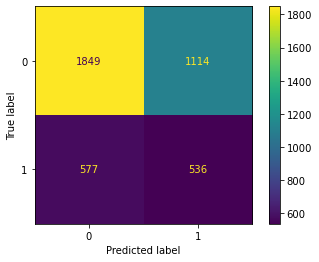

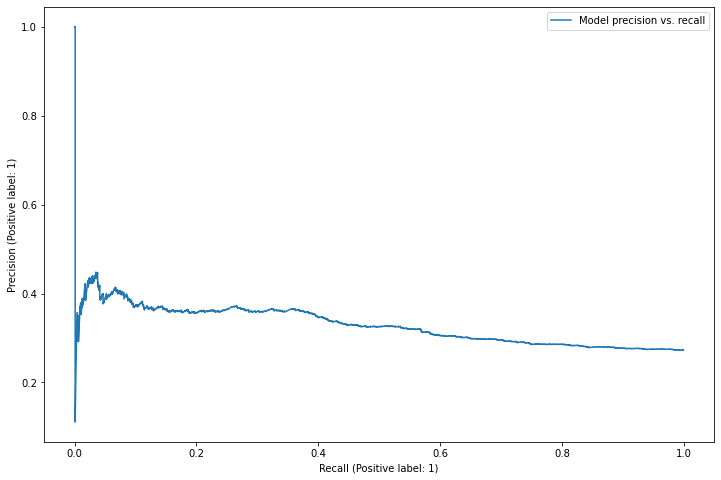

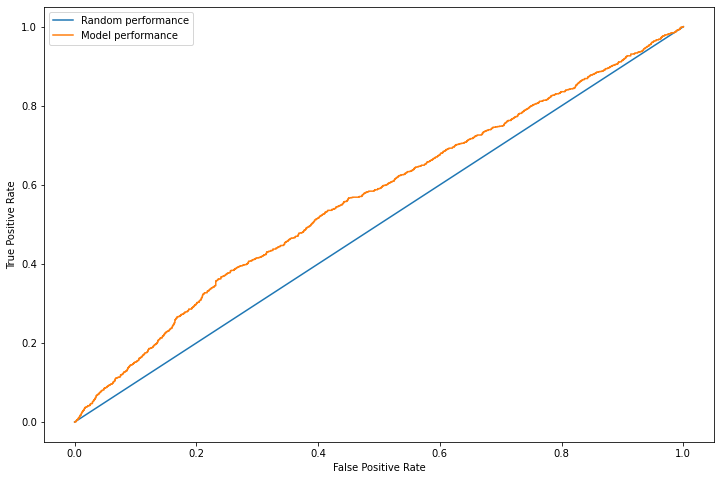

In [15]:
mindwandering.evaluate.evaluate_model_results(df_label, predictions, probabilities['true'])

This model doesn't have very good accuracy yet.  Though the auc-roc score is about in the middle of those reported in the reference paper.  These I think
are the parameter settings they were reporting for the best models they were getting.  

I still have questions if logistic regression really is going to be the best performer of standard ML methods, that never seemed correct in the
reference paper.  The auc-roc score seems to be doing something.  We should try and do a more thorough grid search on logistic regression
models then in the next replication, and see if we can improve logistic regression into the range they reported as the best models they achieved.